# Tutorial

Use data from [ERA5-Land](https://www.ecmwf.int/en/era5-land) to examine time scales of variability in surface variables at the grid point closest to HU Beltsville.

This tutorial is part of [zmoon92/hu-pbl-workshop-2020/tree/master/python-tutorial](https://github.com/zmoon92/hu-pbl-workshop-2020/tree/master/python-tutorial).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import xarray as xr

In [2]:
%matplotlib notebook

plt.rcParams.update({
    "figure.autolayout": True,
    "axes.xmargin": 0,
})

# define some defaults
xrp = {
    "size": 5.2,  # height; if we pass it to xarray plot methods, it will create a new fig
    "aspect": 1.6,  # aspect * size = width
}
figsize = (xrp["size"]*xrp["aspect"], xrp["size"])  # width, height

## Pre

### Load the data

According to [the GRUAN page](https://www.gruan.org/network/sites/beltsville), we want to the point closest to 39.0542 °N, 76.8775 °W. In ERA5-Land, which has a resolution of 0.1°, this turns out to be the point 39.1, -76.9. I have already extracted a few years of data for that point to the file `era5-land_bel.nc`. This file is available if you are running the notebook on the MyBinder for the repo (or have cloned the repo). Otherwise, you will need to download it.

Examine the data set.

You can interact with its fancy HTML representation, which will show up if you have xarray [v0.15.1+](http://xarray.pydata.org/en/stable/whats-new.html#v0-15-1-23-mar-2020).

In [3]:
ds = xr.open_dataset("era5-land_bel.nc")
ds

<xarray.Dataset>
Dimensions:    (time: 87648)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 2010-01-01 ... 2019-12-31T23:00:00
Data variables:
    u10        (time) float32 ...
    v10        (time) float32 ...
    d2m        (time) float32 ...
    t2m        (time) float32 ...
    slhf       (time) float32 ...
    ssr        (time) float32 ...
    sp         (time) float32 ...
    sshf       (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-11 18:12:44 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

Examine a variable.

In [4]:
ds.t2m

<xarray.DataArray 't2m' (time: 87648)>
array([273.7909 , 273.67902, 273.67023, ..., 283.02155, 281.76373, 280.85593],
      dtype=float32)
Coordinates:
    longitude  float32 -76.9
    latitude   float32 39.1
  * time       (time) datetime64[ns] 2010-01-01 ... 2019-12-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

### Sample time series plots

<IPython.core.display.Javascript object>


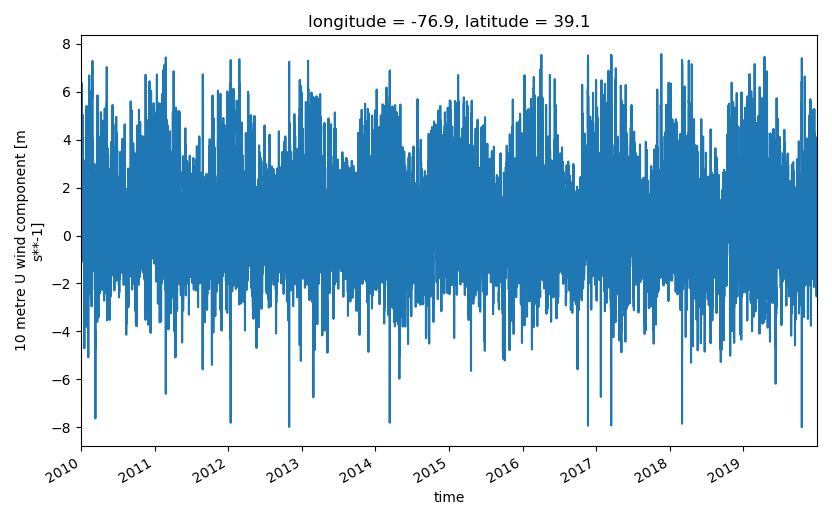

In [5]:
ds.u10.plot.line(**xrp);

Notice how xarray does all of the labeling for us, including units and descriptive name for the variable being plotted. This is possible because the data set we have loaded follows the [CF Conventions](https://cfconventions.org/), specifying `units` and `long_name` attributes for each variable.

<IPython.core.display.Javascript object>


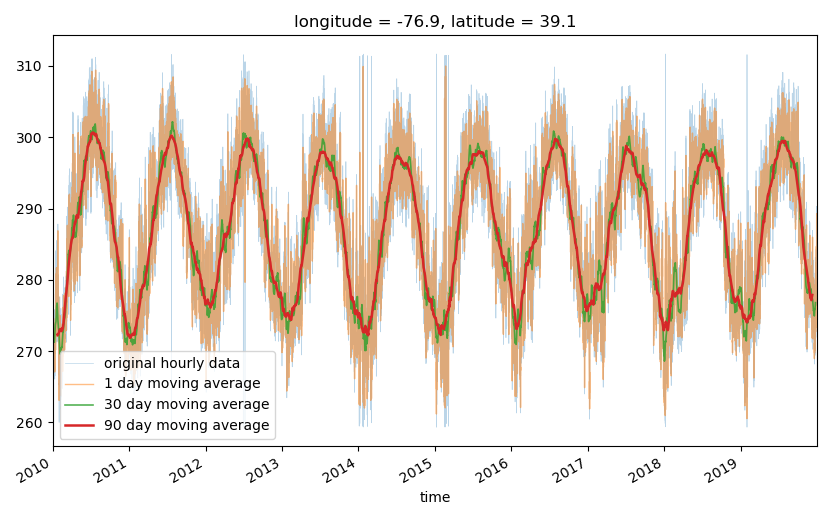

In [6]:
ds.t2m.plot.line(**xrp, lw=0.5, alpha=0.3, label="original hourly data")

# add some moving averages (the time resolution is 1 hour)
ds.t2m.rolling(time=12, center=True).mean().plot(lw=1.0, alpha=0.5, label="1 day moving average")
ds.t2m.rolling(time=12*30, center=True).mean().plot(lw=1.2, alpha=0.8, label="30 day moving average")
ds.t2m.rolling(time=12*90, center=True).mean().plot(lw=1.8, alpha=1.0, label="90 day moving average")
plt.legend();

Relationship between the sensible heat flux and near-surface air temperature?

<IPython.core.display.Javascript object>


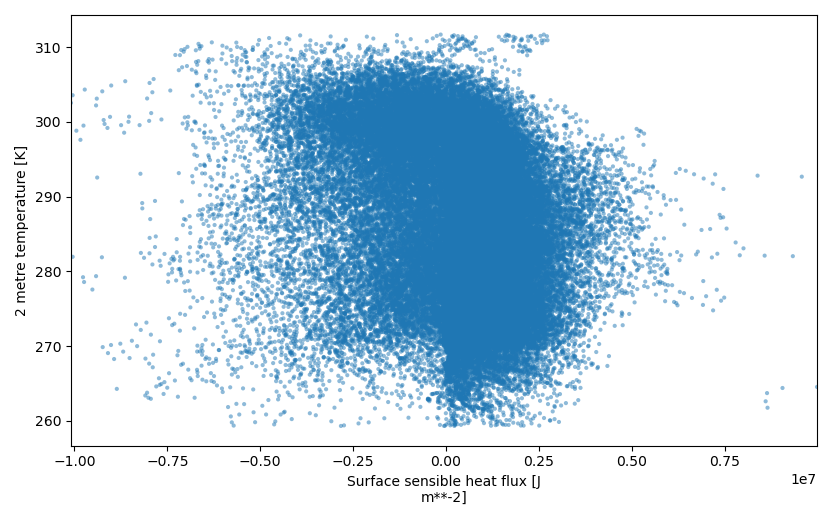

In [7]:
ds.plot.scatter(x="sshf", y="t2m", marker=".", alpha=0.5, edgecolors="none", **xrp);

How about at midday in the summer?

<IPython.core.display.Javascript object>


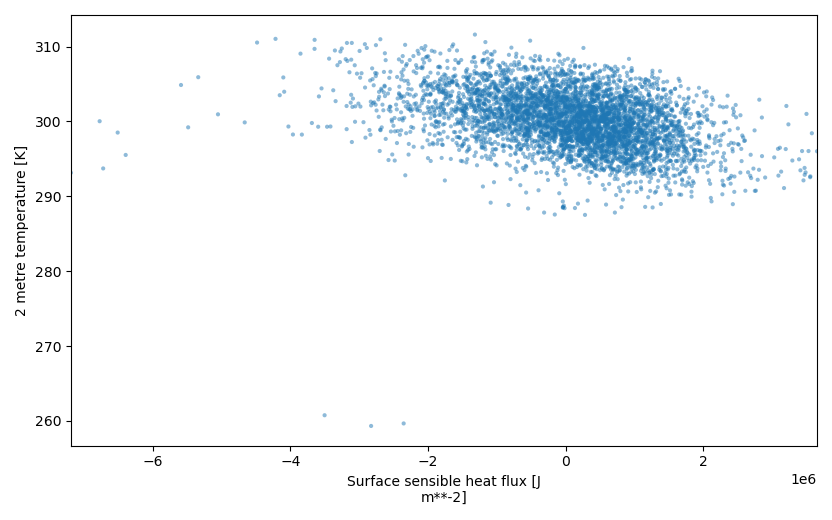

In [8]:
h = ds.time.dt.hour
mo = ds.time.dt.month
ds.where(
    (h >= 14) & (h <= 18) & (mo >= 6) & (mo <= 8)
).plot.scatter(x="sshf", y="t2m", marker=".", alpha=0.5, edgecolors="none", **xrp);

## Tutorial problems

### Compare variables to Sun position

Which have the strongest correlation?

We can compute Sun position with [pvlib](https://pvlib-python.readthedocs.io/en/stable/). [Astropy](https://www.astropy.org/) could also be used for this.

In [9]:
sun_pos = pvlib.solarposition.get_solarposition(ds.time.values, ds.latitude.values, ds.longitude.values)
sun_pos

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2010-01-01 00:00:00,113.488931,113.488931,-23.488931,-23.488931,258.670656,-3.299708
2010-01-01 01:00:00,125.025186,125.025186,-35.025186,-35.025186,267.369562,-3.319362
2010-01-01 02:00:00,136.637273,136.637273,-46.637273,-46.637273,277.270950,-3.339007
2010-01-01 03:00:00,147.929856,147.929856,-57.929856,-57.929856,290.368044,-3.358643
2010-01-01 04:00:00,157.951579,157.951579,-67.951579,-67.951579,311.645243,-3.378271
...,...,...,...,...,...,...
2019-12-31 19:00:00,67.197831,67.237473,22.802169,22.762527,207.285934,-2.982273
2019-12-31 20:00:00,73.654821,73.711018,16.345179,16.288982,220.217119,-3.002181
2019-12-31 21:00:00,81.951171,82.061483,8.048829,7.938517,231.453267,-3.022080
2019-12-31 22:00:00,91.748073,91.748073,-1.748073,-1.748073,241.294639,-3.041970


Add some of the Sun position variables to our data set.

In [10]:
zen_deg = sun_pos["zenith"]
zen = zen_deg.apply(np.deg2rad)
ds["sza"] = ("time", zen_deg, {"long_name": "solar zenith angle", "units": "deg"})
ds["mu"] = ("time", zen.apply(np.cos), {"long_name": "cos(sza)", "units": ""})
ds["selev"] = ("time", sun_pos["elevation"], {"long_name": "solar elevation angle", "units": "deg"})

<IPython.core.display.Javascript object>


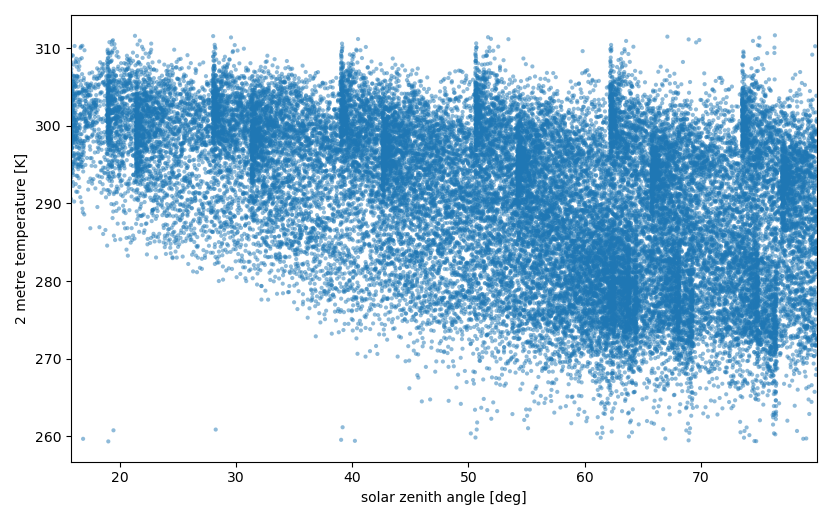

In [11]:
day = ds.time.where(ds.selev > 10).dropna("time")

ds.sel(time=day).plot.scatter(x="sza", y="t2m", marker=".", alpha=0.5, edgecolors="none", **xrp);

In [12]:
# Explore the data, both Sun position and ERA5 surface variables
...

### Compare SZA and near-surface temperature

It is well-known that the warmest temperatures generally lag the minimum solar zenith angle (SZA), on both seasonal and hourly (diurnal cycle) time scales.

Find what that lag is.
* seasonal: for each year find the lag between the yearly minimum SZA and daily maximum temperatue
* diurnal: ...

In [13]:
# for each year, calculate the two times and substract them
...

### Remove seasonal cycle

This is often done in statistical analyses so that the seasonal cycle doesn't dominate the signal when looking for relationships.

A common method is to represent the seasonal cycle using a number of harmonics, e.g., 10.

Examine the estimated seasonal cycles of different variables and the time series with seasonal cycles removed, using the function provided below to calculate the seasonal cycles.

In [14]:
# calculate t_year (here hour-of-year, cf. day-of-year, which the .dt accessors provide) so we can group by it
# I would like to know a better (more elegant) way to do this...
t_year = ds.time - np.r_[[np.datetime64(f"{x}", "D") for x in ds.time.dt.year.values]]
ds["t_in_year"] = ("time", t_year, {"long_name": "time-in-year"})
t_year_leap = ds["t_in_year"].where(ds.time.dt.year == 2016, drop=True).drop(["latitude", "longitude"], drop=True)
# decDOY instead??

<IPython.core.display.Javascript object>


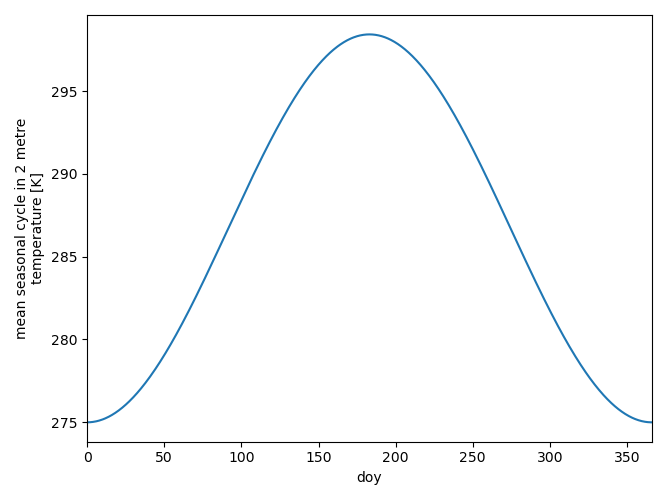

<IPython.core.display.Javascript object>


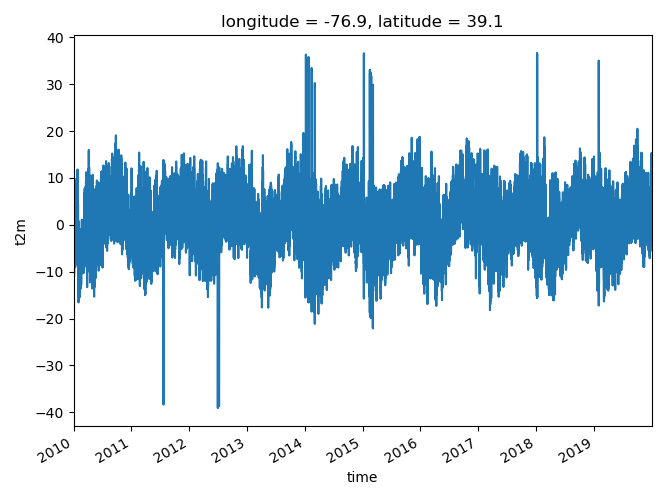

In [15]:
from scipy.fftpack import rfft, irfft
import pandas as pd

def compute_sc(da, n_harm=10):
    "Compute the mean seasonal cycle, given an xr.DataArray."
    x = da.groupby(ds.t_in_year).mean().values  # group by hour in year
    #x = da.values
    z = rfft(x)
    z[n_harm:] = 0
    return xr.DataArray(
        name=f"sc_{da.name}", data=irfft(z), dims="doy", coords=[t_year_leap.dt.days + t_year_leap.dt.seconds / (24*3600)],
        attrs={"long_name": f"mean seasonal cycle in {da.attrs['long_name']}", "units": da.attrs["units"]},
    )

sc = compute_sc(ds.t2m, 2)
    
sc.plot(size=5)


t2m = ds.t2m
doy = t2m.time.dt.dayofyear
year = t2m.time.dt.year
t2m_2 = t2m.groupby(year).map(lambda x: x - sc[0:x.size].values)  # allow for leap years

t2m_2.plot(size=5);